## <u>SCA6.0 - The G protein family<u/>

**Summary:**  This script describes the basic flow of analytical steps in SCA6.0, using the G-protein (small GTPase, Ras-like) family as an example (PFAM PF00071). The analysis consists of five steps, which directly follow from the accompanying publication (Rivoire et al, "An Evolution-Based Functional Decomposition of Natural Proteins"):

**1)  Alignment processing and composition.**
We begin by analyzing the composition of the mulitple sequence alignment: what is the number of effective sequences, and how are the sequences structured into families? For the G-protein family, the PFAM alignment sequence space is well-sampled and fairly homogeneous (unstructured), as evidenced by the fact that overall alignment sequence similarity shows a unimodal distribution near 25%. 

**2) First-order statistics: position-specific conservation.**
Next, we examine overall positional conservation for the sequence alignment. This shows the expected result, that a handful of positions are strongly conserved. 

**3) Second-order statistics: conserved correlations.**
Plots of the SCA matrix ($\tilde{C_{ij}}$), the associated eigenvectors and eigenspectrum, and the corresponding independent components (IC). We choose the number of significant eigenmodes, $k^* = 4$,  by comparison of the eigenspectrum of $\tilde{C_{ij}}$ to that for a collection of 10 randomized alignments.  

**4) Sector decomposition.**
Sector definition based on the top $k^*$ ICs.  We begin by fitting the top $k^*$ statistically significant ICs to a t-distribution, and then identify the amino acid positions contributing to the top five percent of the corresponding cumulative density function. We then construct a sub-matrix of $\tilde{C_{ij}}$ that contains only the selected top-scoring positions for the $k^*$ ICs, ordered by their degree of contribution to each IC. This plot is used to choose sector assignments. For the g-protein family, we define two sectors, sector 1 composed of ICs 1,2, and 3, and sector 2 composed of IC 4. Related to Figs. 4 and 5 of the main text. 

**5) Sequence subfamilies and the basis of sector hierarchy. **
We relate the two sectors (and underlying ICs) to the pattern of divergence between amino acid sequences.  To do this, we make a mapping between sequence space and positional correlations using singular value decomposition. We see that the amino acid positions associated with IC1 and IC2 differentiate between different g-protein subclasses, suggesting that these regions might tune allosteric regulation in a subclass specific way. 
 
<br\>

Prior to running this tutorial, the core calculation scripts must be executed from the command line as follows:
    >> ./scaProcessMSA.py Inputs/PF00071_rd2.an -s 5P21 -c A -f 'Homo sapiens' -t -n
    >> ./scaCore.py Outputs/PF00071_rd2.db
    >> ./scaSectorID.py Outputs/PF00071_rd2.db

Note that we supply pre-annotated alignments for all tutorial scripts *(the annotate_pfMSA step is slow, and should only be run once)*.

**O.Rivoire, K.Reynolds and R.Ranganathan**
1/2015

In [1]:
%matplotlib inline
from __future__ import division

import os
import time
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy.cluster.hierarchy as sch
from scipy.stats import scoreatpercentile 
import matplotlib.image as mpimg
from IPython.display import display
from IPython.display import Image
from Bio.Seq import Seq
from Bio import motifs
import colorsys
import scaTools as sca
import mpld3
import cPickle as pickle
from optparse import OptionParser

if not os.path.exists('Outputs/'): os.makedirs('Outputs/')  

To begin, we read in the results of the above three scripts (scaProcessMSA, scaCore and scaSectorID), stored as three dictionaries in the database PF00071_full.db.  To see what variables are stored in each dictionary, use the command dictionary.keys( ), e.g.:

    >>> print Dseq.keys()

In [2]:
db = pickle.load(open('Outputs/PF00071_rd2.db','rb'))
Dseq = db['sequence']  #the results of scaProcessMSA
Dsca = db['sca']       #the results of scaCore
Dsect = db['sector']   #the results of scaSectorID

### I. Alignment processing and composition

First, we print out a few statistics describing the alignment:

In [3]:
print("After processing, the alignment size is %i sequences and %i positions" % \
      (Dseq['Nseq'], Dseq['Npos']))
print("With sequence weights, there are %i effective sequences" % (Dseq['effseqs']))

After processing, the alignment size is 4974 sequences and 158 positions
With sequence weights, there are 3366 effective sequences


To examine alignment composition, we plot a histogram of all pairwise sequence identities *(left panel)* and a global view of the sequence similarity matrix (defined by $S\equiv \frac{1}{L}XX^\top$) *(right panel)*.  The data show that the alignment is described by a nearly homogeneous distribution of sequence identities with a mean value of about 25%.

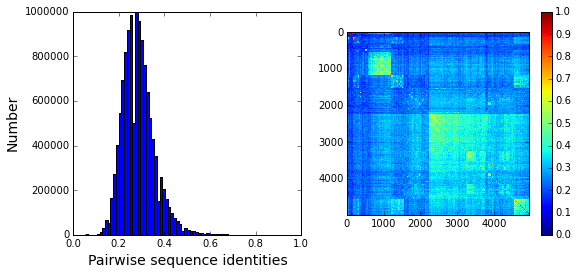

In [4]:
# List all elements above the diagonal (i<j):
listS = [Dsca['simMat'][i,j] for i in range(Dsca['simMat'].shape[0]) \
         for j in range(i+1, Dsca['simMat'].shape[1])]
#Cluster the sequence similarity matrix
Z = sch.linkage(Dsca['simMat'],method = 'complete', metric = 'cityblock')
R = sch.dendrogram(Z,no_plot = True)
ind = map(int, R['ivl'])
#Plotting
plt.rcParams['figure.figsize'] = 9, 4 
plt.subplot(121)
plt.hist(listS, Dseq['Npos']/2)
plt.xlabel('Pairwise sequence identities', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.subplot(122)
plt.imshow(Dsca['simMat'][np.ix_(ind,ind)], vmin=0, vmax=1); plt.colorbar();

**Sequence annotations:** We construct a dictionary of phylogenetic annotations (parsed from the sequence headers) and check the representation of sequences in the top taxonomic levels. For each level, we print a list of taxonomic classes, and the number of sequences found for each. 

In [5]:
#construct a dictionary of phylogenetic groups
annot = dict()
for i, h in enumerate(Dseq['hd']):
    hs = h.split('|')
    annot[hs[0]] = sca.Annot(hs[1], hs[2], hs[3].replace('.',''))
    
# Most frequent taxonomic groups:
atleast = 10
for level in range(4):
    descr_list = [a.taxo.split(',')[level] for a in annot.values() \
                  if len(a.taxo.split(',')) > level]
    descr_dict = {k:descr_list.count(k) for k in descr_list \
                  if descr_list.count(k)>=atleast}
    print '\n Level %i:' % level
    print descr_dict    


 Level 0:
{'Eukaryota': 4879, 'Bacteria': 74}

 Level 1:
{'Ichthyosporea': 22, 'stramenopiles': 159, 'Alveolata': 530, 'Oxymonadida': 14, 'Choanoflagellida': 47, 'Viridiplantae': 192, 'Parabasalia': 321, 'Bacteroidetes': 18, 'Amoebozoa': 510, 'Fungi': 702, 'Metazoa': 2048, 'Cyanobacteria': 20, 'Diplomonadida': 32, 'Heterolobosea': 143, 'Euglenozoa': 148, 'Proteobacteria': 27}

 Level 2:
{'Schizopyrenida': 143, 'Blastocystis': 20, 'Trichomonadida': 320, 'Dikarya': 622, 'Bacillariophyta': 23, 'Echinodermata': 46, 'Porifera': 105, 'Capsaspora': 22, 'Apicomplexa': 89, 'Mycetozoa': 255, 'Chytridiomycota': 15, 'Fungi incertae sedis': 17, 'Pelagophyceae': 25, 'Codonosigidae': 22, 'Streptophyta': 137, 'Perkinsea': 32, 'Hexamitidae': 32, 'Salpingoecidae': 25, 'Archamoebae': 255, 'Chordata': 985, 'Platyhelminthes': 89, 'Oomycetes': 67, 'Kinetoplastida': 148, 'Arthropoda': 520, 'Microsporidia': 46, 'Placozoa': 44, 'Gammaproteobacteria': 10, 'Ciliophora': 408, 'Nematoda': 175, 'PX clade': 24, 'Ch

Based on this, we select taxonomic groups and associate them to colors for representation.  We choose broad taxonomic groups that are well-represented in the alignment (corresponding to Level 1). To see a complete legend that maps numeric codes to color, use: 
    
    >>> sca.figColors()

In [6]:
phylo = list();
fam_names = ['Metazoa', 'Amoebozoa', 'Viridiplantae', 'Fungi',\
             'Alveolata', 'Parabasalia']
col = (0, 0.6, 0.38, 0.18, 0.8, 0.5) 
#Metazoa = red, Amoebozoa = yellow, Viridiplantae = green, 
#Fungi = cyan, Alveolata = blue, Parabasalia = purple
for i,k in enumerate(fam_names):
    sf = sca.Unit()
    sf.name = fam_names[i].lower()
    sf.col = col[i]
    sf.items = [j for j,q in enumerate(Dseq['hd'])  if sf.name in q.lower()]
    phylo.append(sf)

We also attempt to annotate the sequences by their declared sub-class of G protein - Ras, Rab, Rac, and Rho.  These annotations are simply parsed from the header, and could contain mis-assignments.

In [7]:
gprot_names = ['Ras', 'Rab', 'Rac','Rho']
gprot_classes = list()
col = (0, 0.65, 0.15, 0.38)
#Ras=light blue, Rab = orange, Rac=yellow, Rho=dark blue
for c,k in enumerate(gprot_names):
    gp = sca.Unit()
    gp.col = col[c]
    gp.name = k
    gp.items = [i for i,h in enumerate(Dseq['hd']) if k in h]
    gprot_classes.append(gp)

To examine the relationship between global sequence similarity, phylogeny, and functional sub-class, we plot the top six independent components of the sequence correlation matrix (including sequence weights). In these plots, each point represents a particular sequence, and the distance between points reflects global sequence identity. In the top row each point (sequence) is color coded by phylogenetic annotation, in the bottom row, they are color-coded by g-protein class.

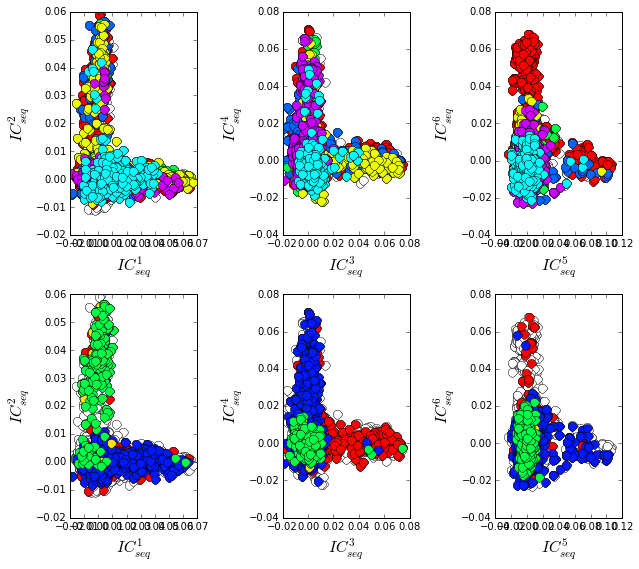

In [8]:
plt.rcParams['figure.figsize'] = 9, 8
U = Dsca['Uica'][1]
pairs = [[2*i,2*i+1] for i in range(3)]
for k,[k1,k2] in enumerate(pairs):
    plt.subplot(2,3,k+1)
    sca.figUnits(U[:,k1], U[:,k2], phylo)
    plt.xlabel(r"$IC_{seq}^{%i}$"%(k1+1), fontsize=16)
    plt.ylabel(r"$IC_{seq}^{%i}$"%(k2+1), fontsize=16)
    plt.subplot(2,3,k+4)
    sca.figUnits(U[:,k1], U[:,k2], gprot_classes)
    plt.xlabel(r"$IC_{seq}^{%i}$"%(k1+1), fontsize=16)
    plt.ylabel(r"$IC_{seq}^{%i}$"%(k2+1), fontsize=16)
plt.tight_layout()

The data show a mixed distribution of phylogenetic groups along modes 1-5.  A subset of metazoan sequences emerges along the mode six, $IC^{6}_{seq}$.  In contrast, the top modes of the sequence similarity matrix do seem to correspond to functional G protein subclasses. For example, the Rho proteins *(green)* emerge along $IC^{2}_{seq}$ , the Ras proteins *(red)* along $IC^{3}_{seq}$, and a subset of Rabs *(blue)* along $IC^{4}_{seq}$ and $IC^{5}_{seq}$ and a subset of Ras proteins along $IC^{6}_{seq}$. Many G-protein paralogs (reflecting different subclasses) can be found in each type of organism, and thus the global pattern of sequence divergence is distinct from phylogeny.

### II. <u> First-order statistics: position-specific conservation.  <u/>

Plot the position-specific conservation values for each g-protein position. $D_i$ is calculated according to equation S4 (supplemental information).

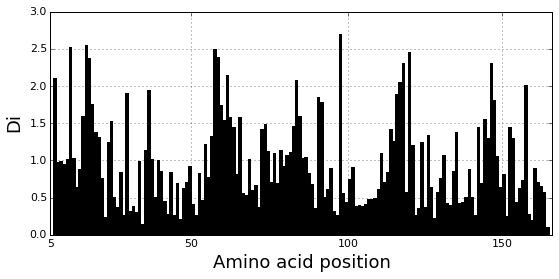

In [9]:
fig, axs = plt.subplots(1,1, figsize=(9,4))
xvals = [i+1 for i in range(len(Dsca['Di']))]
xticks = [0,45,95,144]
plt.bar(xvals,Dsca['Di'], color='k')
plt.tick_params(labelsize=11); plt.grid()
axs.set_xticks(xticks);
labels = [Dseq['ats'][k] for k in xticks]
axs.set_xticklabels(labels);
plt.xlabel('Amino acid position', fontsize=18); plt.ylabel('Di', fontsize=18);

### III. <u>Second-order statistics: conserved correlations.<u/>

Plot the SCA correlation matrix ( $\tilde{C_{ij}}$ ) computed according to Equations 4+5

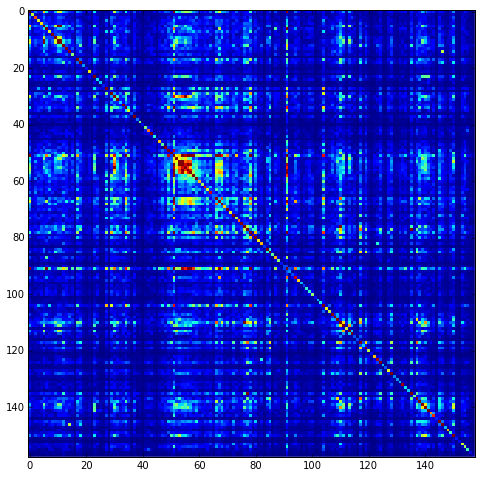

In [10]:
plt.rcParams['figure.figsize'] = 13, 8
plt.imshow(Dsca['Csca'], vmin=0, vmax=1.4,interpolation='none',\
           aspect='equal')

Plot the eigenspectrum of (1) the SCA positional coevolution matrix ($\tilde{C_{ij}}$) *(black bars)* and (2) 10 trials of matrix randomization for comparison. This graph is used to choose the number of significant eigenmodes ($k^* = 4$).

In [11]:
plt.rcParams['figure.figsize'] = 9, 4 
hist0, bins = np.histogram(Dsca['Lrand'].flatten(), bins=Dseq['Npos'], \
                           range=(0,Dsect['Lsca'].max()))
hist1, bins = np.histogram(Dsect['Lsca'], bins=Dseq['Npos'], \
                           range=(0,Dsect['Lsca'].max()))
plt.bar(bins[:-1], hist1, np.diff(bins),color='k')
plt.plot(bins[:-1], hist0/Dsca['Ntrials'], 'r', linewidth=3)
plt.tick_params(labelsize=11)
plt.xlabel('Eigenvalues', fontsize=18); plt.ylabel('Numbers', fontsize=18);
print 'Number of eigenmodes to keep is %i' %(Dsect['kpos'])
mpld3.display()

Number of eigenmodes to keep is 4


Plot the top significant eigenmodes *(top row)* and associated independent components *(bottom row)*. The ICs are an optimally independent representation of the four different residue groups.

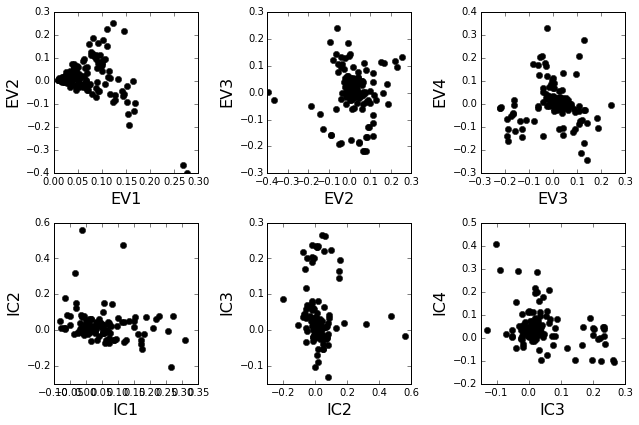

In [12]:
plt.rcParams['figure.figsize'] = 9, 6
pairs = [[0,1],[1,2],[2,3]]
EVs = Dsect['Vsca']
ICs = Dsect['Vpica']
for k,[k1,k2] in enumerate(pairs):
    plt.subplot(2,3,k+1)
    plt.plot(EVs[:,k1], EVs[:,k2], 'ok')
    plt.xlabel("EV%i"%(k1+1), fontsize=16)
    plt.ylabel("EV%i"%(k2+1), fontsize=16)
    plt.subplot(2,3,k+4)
    plt.plot(ICs[:,k1], ICs[:,k2], 'ok')
    plt.xlabel("IC%i"%(k1+1), fontsize=16)
    plt.ylabel("IC%i"%(k2+1), fontsize=16)
plt.tight_layout()

### IV. <u> Sector decomposition. <u/>

To define the positions with significant contributions to each of the independent components (ICs), we make a empirical fit for each IC to the t-distribution and select positions with greater than a specified cutoff on the CDF.  We choose $p=0.95$ as our cutoff.  Note that since some positions might contribute significantly to more than one IC (an indication of non-independence of ICs), we  apply a simple algorithm to assign such positions to one IC.  Specifically, we assign positions to the IC with which it has the greatest degree of co-evolution.<br/>

The data indicate generally good fits for the top five ICs (also shown in supplemental figure S2), and we return the positions contributing to each IC in a format suitable for cut and paste into PyMol.  

IC 1 is composed of 18 positions:
22+32+34+36+39+54+63+64+68+71+73+75+81+83+85+110+116+144

IC 2 is composed of 8 positions:
5+11+56+61+62+72+96+99

IC 3 is composed of 16 positions:
10+14+15+16+28+35+57+58+59+60+117+119+145+146+147+156

IC 4 is composed of 11 positions:
17+23+82+90+115+123+125+130+134+141+143



/Users/kreynolds/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


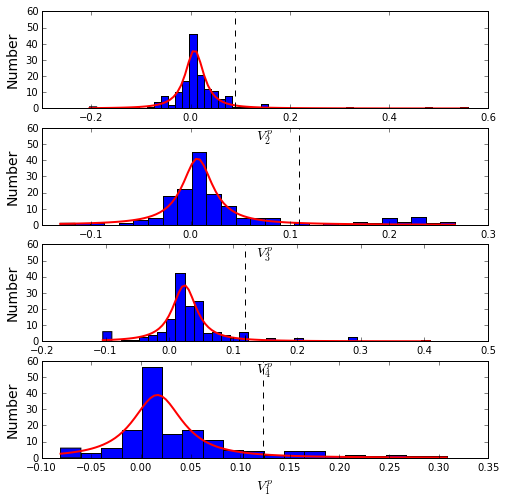

In [13]:
plt.rcParams['figure.figsize'] = 8, 8 

Vpica = Dsect['Vpica']
for k in range(Dsect['kpos']):
    iqr = scoreatpercentile(Vpica[:,k],75) - scoreatpercentile(Vpica[:,k],25)
    binwidth=2*iqr*(len(Vpica)**(-0.33))
    nbins=round((max(Vpica[:,k])-min(Vpica[:,k]))/binwidth)
    plt.subplot(Dsect['kpos'],1,k)
    h_params = plt.hist(Vpica[:,k], nbins)
    x_dist = np.linspace(min(h_params[1]), max(h_params[1]), num=100)
    plt.plot(x_dist,Dsect['scaled_pd'][k],'r',linewidth = 2)  
    plt.plot([Dsect['cutoff'][k],Dsect['cutoff'][k]], [0,60], 'k--',linewidth = 1)
    plt.xlabel(r'$V^p_{%i}$'%(k+1), fontsize=14)
    plt.ylabel('Number', fontsize=14)
    
for n,ipos in enumerate(Dsect['ics']):
    sort_ipos = sorted(ipos.items)
    ats_ipos = ([Dseq['ats'][s] for s in sort_ipos])
    ic_pymol = ('+'.join(ats_ipos))
    print('IC %i is composed of %i positions:' % (n+1,len(ats_ipos)))
    print(ic_pymol + "\n")
        

To define protein sectors, we examine the structure of the SCA positional correlation matrix with positions contributing to the top  independent components (ICs) ordered by weight (*left panel*).  This provides a basis to determine/interpret which ICs are truly statistically independent (defining an independent sector) and which represent hierarchical breakdowns of one sector. In this case, the data suggest that ICs 1, 2, and 3 have strong inter-IC correlations and should be considered a single sector, and IC4 shows little corrleation with other ICs, implying a distinct sector (see the dendrogram that follows).  In the *right panel* the ICs are re-ordered to reflect this decomposition. 

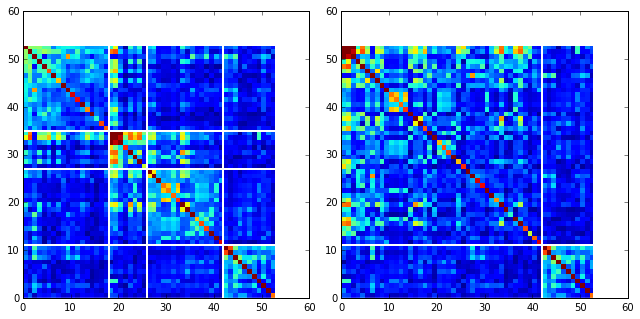

In [14]:
#plot the SCA positional correlation matrix, ordered by contribution to the top ICs
plt.rcParams['figure.figsize'] = 9, 9 
plt.subplot(121)
plt.imshow(Dsca['Csca'][np.ix_(Dsect['sortedpos'], Dsect['sortedpos'])], \
           vmin=0, vmax=2.2,interpolation='none',\
           aspect='equal',extent=[0,sum(Dsect['icsize']),\
                                  0,sum(Dsect['icsize'])])
line_index=0
for i in range(Dsect['kpos']):
    plt.plot([line_index+Dsect['icsize'][i],line_index+Dsect['icsize'][i]],\
             [0,sum(Dsect['icsize'])],'w', linewidth = 2)
    plt.plot([0,sum(Dsect['icsize'])],[sum(Dsect['icsize'])-\
            line_index,sum(Dsect['icsize'])-line_index],'w', linewidth = 2)
    line_index += Dsect['icsize'][i] 

#define the new sector groupings - 3 total
sec_groups = ([0,1,2],[3])
sectors = list()
c = [0.66, 0]
for n,k in enumerate(sec_groups):
    s = sca.Unit()
    all_items = list()
    all_Vp = list()
    for i in k: 
        all_items = all_items+Dsect['ics'][i].items
        all_Vp = all_Vp+list(Dsect['ics'][i].vect)
    svals = np.argsort(all_Vp)    
    s.items = [all_items[i] for i in svals]
    s.col = c[n]
    sectors.append(s)

#plot the re-ordered matrix
plt.subplot(122)
line_index=0
sortpos = list()
for s in sectors:
    sortpos.extend(s.items)
plt.imshow(Dsca['Csca'][np.ix_(sortpos, sortpos)], vmin=0, vmax=2.2,\
           interpolation='none',aspect='equal',\
           extent=[0,len(sortpos),0,len(sortpos)])
for s in sectors:
    plt.plot([line_index+len(s.items),line_index+len(s.items)],\
             [0,len(sortpos)],'w', linewidth = 2)
    plt.plot([0,sum(Dsect['icsize'])],[len(sortpos)-line_index,\
                    len(sortpos)-line_index],'w', linewidth = 2)
    line_index += len(s.items)
plt.tight_layout()

The below dendrogram diagrams the relationship between independent components. In this plot, solid lines represent physically contiguous structural units, and dashed lines indicate spatially fragmented groups of residues. We see that ICs 1,2,and 3 combine to form a single sector (sector 1), and that sector 2 (IC4) is more independent. 

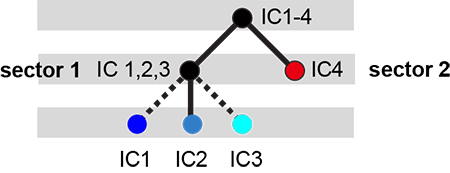

In [15]:
i = Image(filename='figs/Gprot_sec_hier.png'); i

The assignments have clear physical consistency with the concept of sectors as functional, physically contiguous units in the protein structure (see also Figs.4-5).  In the *left panels*,  sector one is formed from the combination of positions in IC1 *(bright blue)*, IC2 *(light blue)* and IC3 *(cyan)*. Sector2 (IC4) is shown in red spheres, and forms a phyically contiguous unit structurally distinct from sector one. 

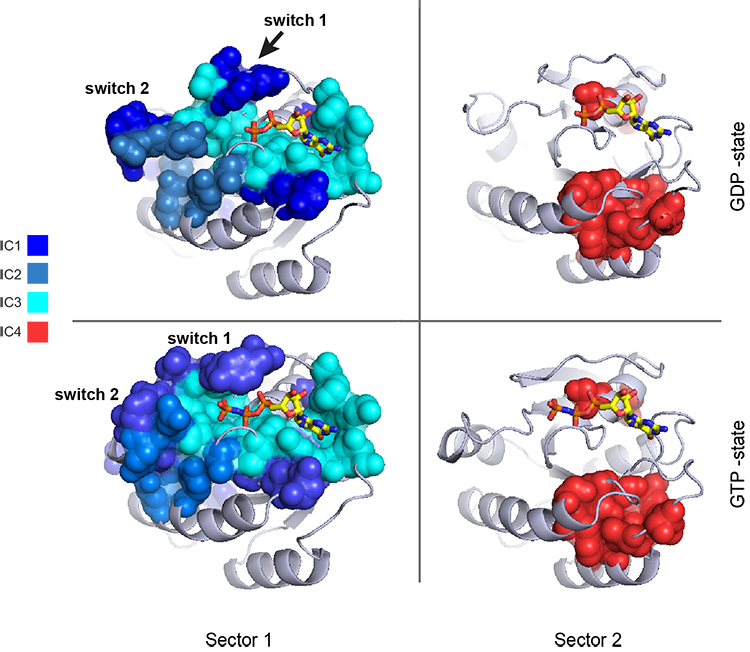

In [16]:
i = Image(filename = 'figs/Gprot_secstruct.png'); i

Print the sector positions, in a format suitable for pyMol, and create a pyMol session (in the Outputs directory) with the sectors (and decomposition into independent components) as seperate objects.

In [17]:
for i,k in enumerate(sectors):
    sort_ipos = sorted(k.items)
    ats_ipos = ([Dseq['ats'][s] for s in sort_ipos])
    ic_pymol = ('+'.join(ats_ipos))
    print('Sector %i is composed of %i positions:' % (i+1,len(ats_ipos)))
    print(ic_pymol + "\n")
sca.writePymol('5P21', sectors, Dsect['ics'], Dseq['ats'], \
               'Outputs/PF00071.pml','A', '../Inputs/', 0)  

Sector 1 is composed of 42 positions:
5+10+11+14+15+16+22+28+32+34+35+36+39+54+56+57+58+59+60+61+62+63+64+68+71+72+73+75+81+83+85+96+99+110+116+117+119+144+145+146+147+156

Sector 2 is composed of 11 positions:
17+23+82+90+115+123+125+130+134+141+143



### V. Sequence subfamilies and the basis of sector hierarchy.

How does the phylogenetic and functional heterogeneity in the MSA influence the sector definitions?  To address this, we take advantage of mathematical methods for mapping between the space of positional and sequence correlations, as described in *Rivoire et al* (see equations 8-11).  Using this mapping, we plot the top $k^*$ ICs of the matrix $\tilde{C_{ij}}$ as 2-D scatter plots *(top row)*, and compare them to the corresponding sequence space divergence *(middle and bottom rows)*.  The amino acid positions contributing to each IC are colored by sector *(sector 1 = blue, sector 2 = red, top row)*. The sequences are color-coded according to phylogenetic classifications *(middle row)* or G-protein class *(bottom row)* as we defined above. 

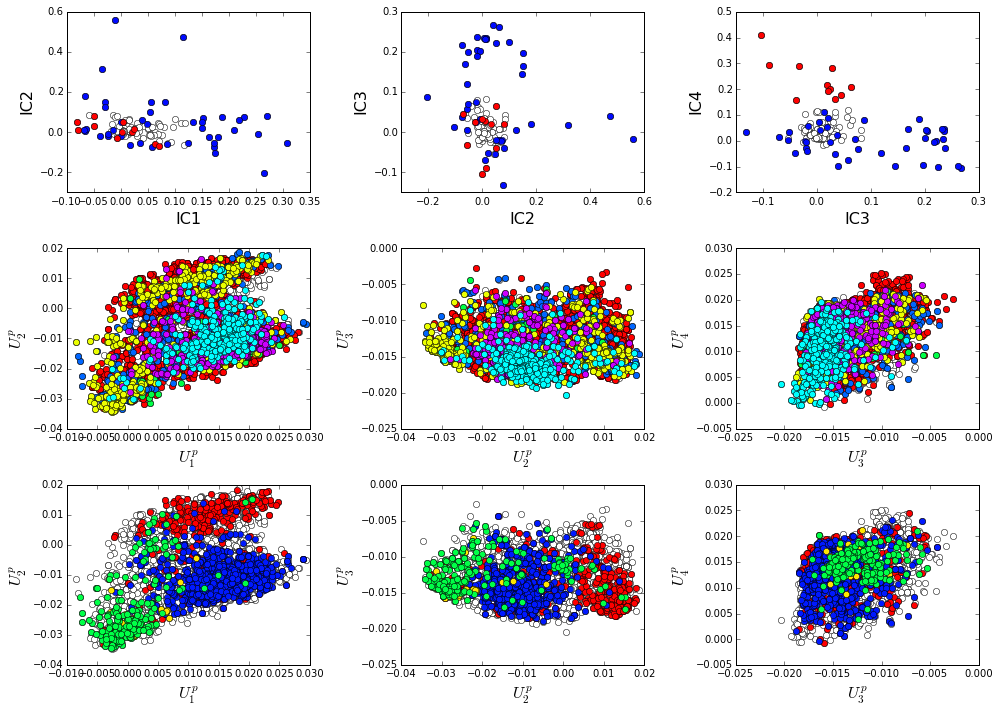

In [18]:
plt.rcParams['figure.figsize'] = 14, 10 
pairs= [[0,1],[1,2],[2,3]]
for n,[k1,k2] in enumerate(pairs):
    plt.subplot(3,3,n+1)
    sca.figUnits(Dsect['Vpica'][:,k1], Dsect['Vpica'][:,k2], \
                 sectors, dotsize = 6)
    plt.xlabel('IC%i' % (k1+1), fontsize=16)
    plt.ylabel('IC%i' % (k2+1), fontsize=16)
    plt.subplot(3,3,n+4)
    sca.figUnits(Dsect['Upica'][:,k1], Dsect['Upica'][:,k2], \
                 phylo, dotsize = 6)
    plt.xlabel(r'$U^p_{%i}$' % (k1+1), fontsize=16)
    plt.ylabel(r'$U^p_{%i}$' % (k2+1), fontsize=16)
    plt.subplot(3,3,n+7)
    sca.figUnits(Dsect['Upica'][:,k1], Dsect['Upica'][:,k2], \
                 gprot_classes, dotsize = 6)
    plt.xlabel(r'$U^p_{%i}$' % (k1+1), fontsize=16)
    plt.ylabel(r'$U^p_{%i}$' % (k2+1), fontsize=16)
plt.tight_layout()

There is some clear divergence in G-protein subtype along $U_1^p$ and $U_2^p$, indicating that the amino acid positions associated with IC1 and IC2 vary in a subtype-specific pattern. To more clearly see seperations in sequence classification, we also plot the above distributions of sequences (along $U_1^p$, $U_2^p$,$U_3^p$,and $U_4^p$) as stacked bar plots. This representation lets us directly see the contribution of sequences that might be hidden (due to overlapping points) on the above scatter plots. The *top row* reflects phylogenetic classifications and the *bottom row* shows G-protein functional classes. 

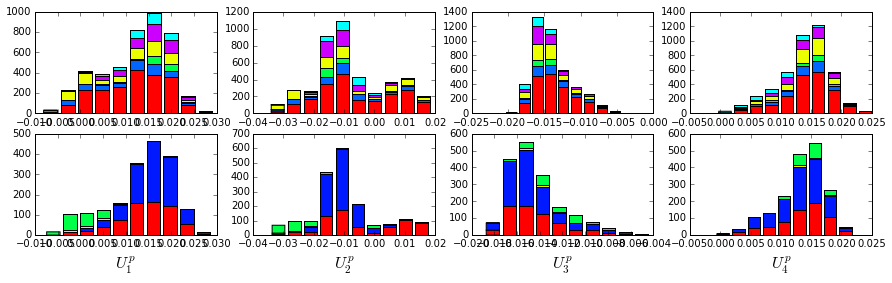

In [19]:
plt.rcParams['figure.figsize'] = 15, 4 

col = list()
for k in gprot_classes:
    col = col + [colorsys.hsv_to_rgb(k.col,1,1)]
for k in range(Dsect['kpos']):
    forhist = list()
    for group in gprot_classes:
        forhist.append([Dsect['Upica'][i,k] for i in group.items])
    plt.subplot(2,Dsect['kpos'],k+5)
    plt.hist(forhist, histtype='barstacked',color=col)
    plt.xlabel(r'$U^p_{%i}$' % (k+1), fontsize=16)
    
col = list()
for k in phylo:
    col = col + [colorsys.hsv_to_rgb(k.col,1,1)]
for k in range(Dsect['kpos']):
    forhist = list()
    for group in phylo:
        forhist.append([Dsect['Upica'][i,k] for i in group.items])
    plt.subplot(2,Dsect['kpos'],k+1)
    plt.hist(forhist, histtype='barstacked',color=col)

The interpretation for the two sectors is clear:

**Sector 1**  is composed of ICs 1,2 and 3 - we see above that the positions contributing to IC1 and IC2 seperate out the Ras-like *(red)* and Rho *(green)* g-protein functional classes (see the plots of $U_1^p$ and $U_2^p$ above). In contrast, the positions along IC3 and IC4 are associated with a homogeneous pattern of sequences; that is they have no obvious relationship to g-protein class or phylogeny. This suggests that sector 1 consists of a core element (IC3) that is conserved among G-proteins and two related/co-evolving parts which diverge in particular G-protein functional classes. The structural mapping of these positions is consistent with this interpretation -  we observe that the positions associated with IC3 form the base of the nucleotide binding pocket (a general feature of the g-protein family) and that the IC1 and IC2 positions form a peripheral shell, which may reflect functional divergence in G-protein regulatory mechanisms in different family members.

**Sector 2**  is defined along ($V_4^p$). The sequences along the corresponding component ($U_4^p$) are homogeneously distributed with respect to both phylogeny and g-protein functional class, consistent with the notion that this sector is likley a global property of the entire alignment. 